## Libraries

In [1]:
import pandas as pd
import numpy as np

## Load the data

In [13]:
train = pd.read_pickle('../features/train_new.pkl')

In [14]:
test = pd.read_pickle('../features/test_new.pkl')

## Feature selection

In [21]:
# features = ['cosin_sim', 'word_share', 'q1_char_num', 'q1_word_num', 'q2_char_num', 'q2_word_num',
#             'start_with_same_world', 'rfidf_share', 'char_difference', 'word_difference',
#            'seq_simhash_distance', 'shingle_simhash_distance', 'avg_word_len_q1', 'avg_word_len_q2',
#            'avg_word_difference', 'unigrams_common_count', 'bigrams_common_count', 'unigrams_common_ratio',
#            'bigrams_common_ratio', 'word2vec_q1_mean', 'word2vec_q2_mean']

features = ['word_share', 'start_with_same_world', 'q1_char_num', 'q2_char_num',
       'q1_word_num', 'q2_word_num', 'rfidf_share', 'char_difference',
       'word_difference', 'seq_simhash_distance', 'shingle_simhash_distance',
       'avg_word_len_q1', 'avg_word_len_q2', 'avg_word_difference',
       'unigrams_common_count', 'bigrams_common_count',
       'unigrams_common_ratio', 'bigrams_common_ratio', 'cosin_sim',
       'word2vec_q1_mean', 'word2vec_q2_mean', 'q1_NN_count', 'q2_NN_count',
       'NN_diff', 'q1_RB_count', 'q2_RB_count', 'RB_diff', 'q1_VB_count',
       'q2_VB_count', 'VB_diff', 'q1_DT_count', 'q2_DT_count', 'DT_diff',
       'q1_JJ_count', 'q2_JJ_count', 'JJ_diff', 'q1_FW_count', 'q2_FW_count',
       'FW_diff', 'q1_RP_count', 'q2_RP_count', 'RP_diff', 'q1_SYM_count',
       'q2_SYM_count', 'SYM_diff']


target = 'is_duplicate'

X = train[features]
y = train[target]

In [26]:
X.head()

,word_share,start_with_same_world,q1_char_num,q2_char_num,q1_word_num,q2_word_num,rfidf_share,char_difference,word_difference,seq_simhash_distance,...,JJ_diff,q1_FW_count,q2_FW_count,FW_diff,q1_RP_count,q2_RP_count,RP_diff,q1_SYM_count,q2_SYM_count,SYM_diff
0,0.727273,1,66,57,14,12,0.772164,9,2,15,...,2,14,12,2,14,12,2,14,12,2
1,0.307692,1,51,88,8,13,0.361758,37,5,22,...,5,8,13,5,8,13,5,8,13,5
2,0.363636,1,73,59,14,10,0.355191,14,4,26,...,4,14,10,4,14,10,4,14,10,4
3,0.000000,0,50,65,11,9,0.000000,15,2,36,...,2,11,9,2,11,9,2,11,9,2
4,0.000000,1,76,39,13,7,0.000000,37,6,34,...,6,13,7,6,13,7,6,13,7,6


## Oversampling

In [34]:
pos_train = X[y == 1]
neg_train = X[y == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

X = pd.concat([pos_train, neg_train])
y = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()

del pos_train, neg_train

0.19124366100096607


## Feature importance

In [22]:
from xgboost import XGBClassifier
from matplotlib import pyplot as plt

In [23]:
model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, subsample=0.5,
                      gamma=1.5, seed=42, colsample_bytree=0.7)
model.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=1.5, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.5)

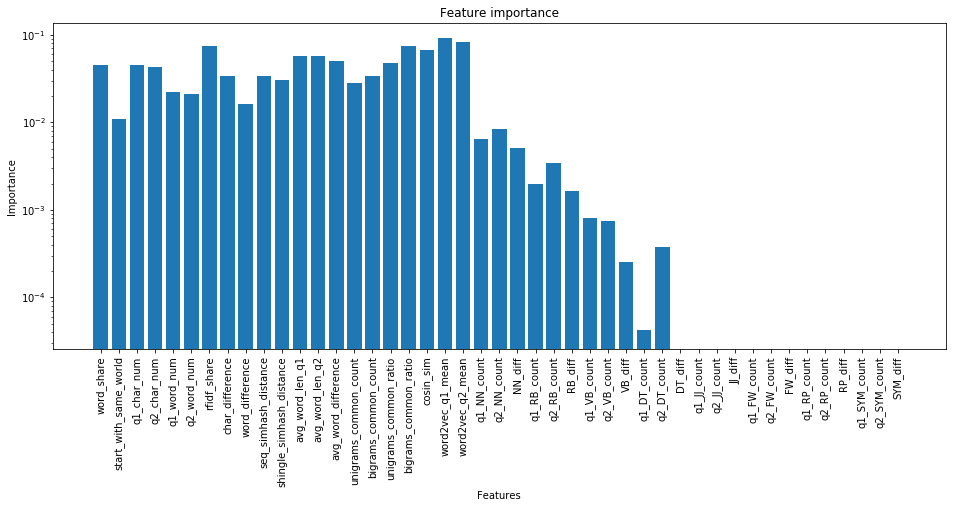

In [24]:
feature_importance = model.feature_importances_

plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')

plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), features, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [25]:
pd.DataFrame(model.feature_importances_, columns=['weights'], index=features)

,weights
word_share,0.045876
start_with_same_world,0.011071
q1_char_num,0.045121
q2_char_num,0.042857
q1_word_num,0.022309
q2_word_num,0.021302
rfidf_share,0.075691
char_difference,0.033715
word_difference,0.016103
seq_simhash_distance,0.033589
